### PROBLEM STATEMENT
**Preprocess** of **Customer Churn Dataset** to prepare it for **Machine Learning** models. The dataset contains information about customers who have churned or not. The goal is to create a preprocessed dataset that can be used for modeling.
### Stages of Preprocessing
1. Encoding categorical variables
2. Handling missing values
3. Scaling/normalizing the data
### Importing Required Python libraries

In [216]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

### Data Preprocessing Pipeline
* **Categorical Feature Encoding**: Convert categorical variables into numerical variables using one-hot, label, or ordinal encoding.
* **Scaling/Normalization**: Scale numerical variables using StandardScaler or MinMaxScaler.
* **Dropping Unnecessary Features**: Remove features that are irrelevant to the model.

In [217]:
class NullsDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.dropna()

In [218]:
class OrdinalFeatureEncoder(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.ordinal_encoder = OrdinalEncoder(
            categories=[['Standard', 'Basic', 'Premium']]
        )

    def fit(self, X, y=None):
        self.ordinal_encoder.fit(X[['Subscription Type']])  # Keep as DataFrame
        return self

    def transform(self, X):
        X_copy = X.copy()  # Avoid modifying the original DataFrame
        encoded_values = self.ordinal_encoder.transform(X_copy[['Subscription Type']])
        X_copy['Subscription Type Encoded'] = encoded_values
        return X_copy

In [219]:
class LabelFeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.gender_label_encoder = LabelEncoder()

    def fit(self, X, y=None):
        self.gender_label_encoder.fit(X['Gender'].values.ravel())  # Convert to 1D
        return self

    def transform(self, X):
        X = X.copy()
        X['Gender Encoded'] = self.gender_label_encoder.transform(X['Gender'].values.ravel())  # Convert to 1D
        return X

In [220]:
class OneHotFeatureEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.one_hot_encoder = OneHotEncoder(sparse_output=False)  # Ensure dense output
    
    def fit(self, X, y=None):
        self.one_hot_encoder.fit(X[['Contract Length']])  # Convert to 2D
        return self
    
    def transform(self, X):
        encoded_array = self.one_hot_encoder.transform(X[['Contract Length']])  # Convert to 2D
        encoded_df = pd.DataFrame(encoded_array, 
                                  columns=self.one_hot_encoder.get_feature_names_out(['Contract Length']), 
                                  index=X.index)  
        return pd.concat([X, encoded_df], axis=1)

In [221]:
class FeatureDropper(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop(['Subscription Type', 'Gender', 'Contract Length', 'Contract Length_Quarterly'], axis=1, errors="ignore")

In [222]:
class FeatureScaler(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.scaler = MinMaxScaler()
        self.feature_names = ['CustomerID', 'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend', 'Last Interaction']

    def fit(self, X, y=None):
        self.scaler.fit(X[self.feature_names])
        return self
    
    def transform(self, X):
        X[self.feature_names] = self.scaler.transform(X[self.feature_names])
        return pd.DataFrame(X, columns=X.columns, index=X.index) if isinstance(X, pd.DataFrame) else X

In [223]:
pipeline = Pipeline([
                ("NullsDropper", NullsDropper()),
                ("OrdinalFeatureEncoder", OrdinalFeatureEncoder()),
                ("LabelFeatureEncoder", LabelFeatureEncoder()),
                ("OneHotFeatureEncoder", OneHotFeatureEncoder()),
                ("FeatureDropper", FeatureDropper()),
                ("FeatureScaler", FeatureScaler())
            ])

### Load Training Dataset

In [224]:
data = pd.read_csv('Data/customer_churn_dataset-training-master.csv')
print(data.columns)

Index(['CustomerID', 'Age', 'Gender', 'Tenure', 'Usage Frequency',
       'Support Calls', 'Payment Delay', 'Subscription Type',
       'Contract Length', 'Total Spend', 'Last Interaction', 'Churn'],
      dtype='object')


### Preprocess the Training Data

In [225]:
train_preprocessed = pipeline.fit_transform(data)
train_preprocessed.head()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Subscription Type Encoded,Gender Encoded,Contract Length_Annual,Contract Length_Monthly
0,0.000000,0.255319,0.644068,0.448276,0.5,0.600000,0.924444,0.551724,1.0,0.0,0,1.0,0.0
1,0.000002,1.000000,0.813559,0.000000,1.0,0.266667,0.507778,0.172414,1.0,1.0,0,0.0,1.0
2,0.000004,0.787234,0.220339,0.103448,0.6,0.600000,0.094444,0.068966,1.0,1.0,0,0.0,0.0
3,0.000007,0.851064,0.627119,0.689655,0.7,0.233333,0.328889,0.965517,1.0,0.0,1,0.0,1.0
4,0.000009,0.106383,0.525424,0.655172,0.5,0.266667,0.574444,0.655172,1.0,1.0,1,0.0,1.0


### Checking Correlation after Preprocessing

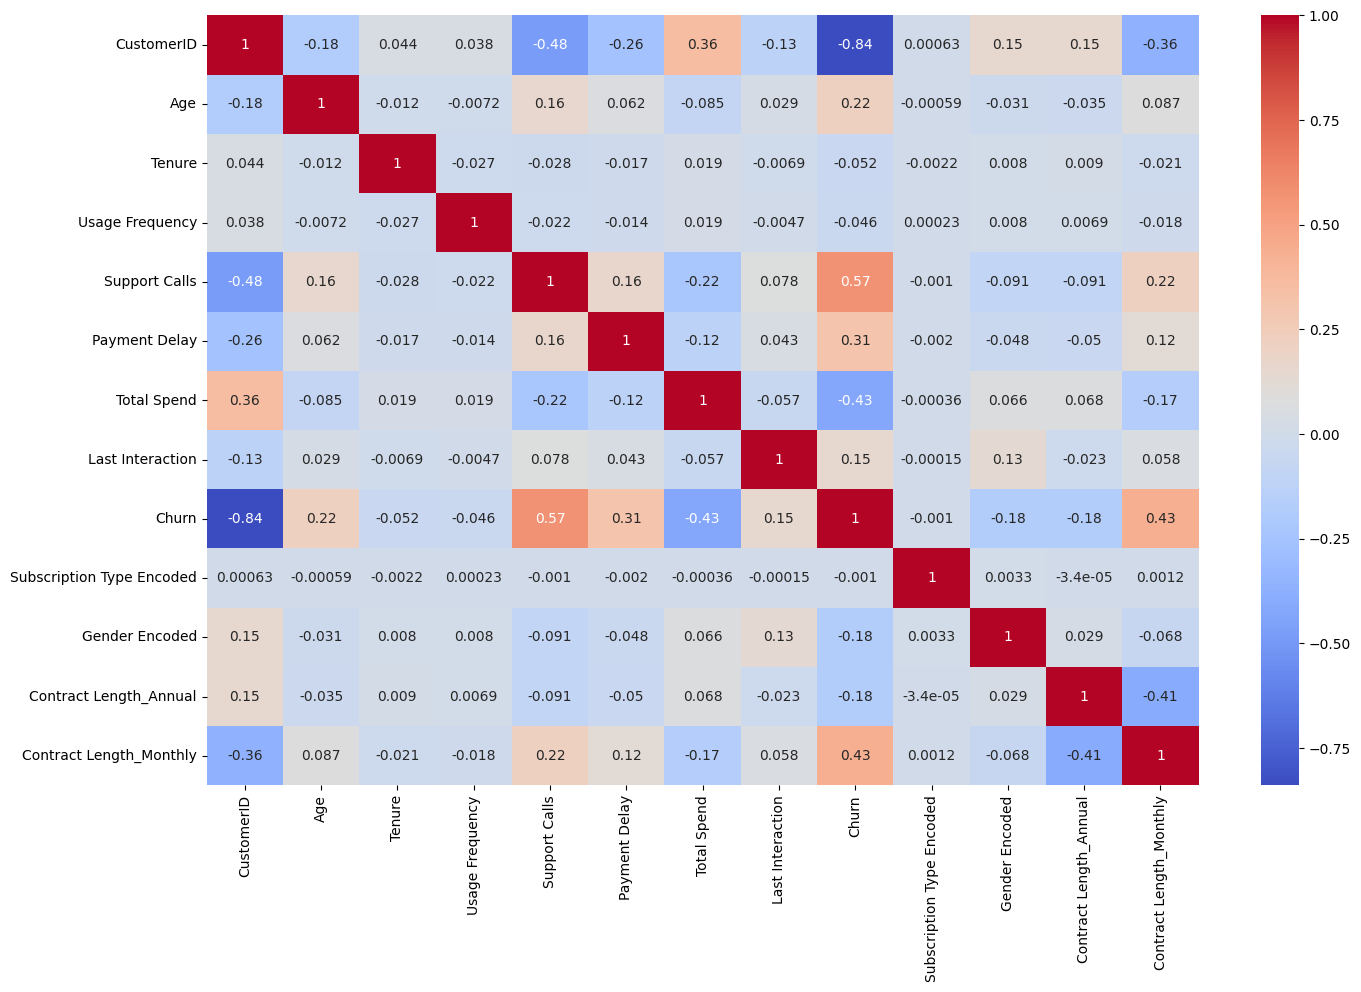

In [226]:
plt.figure(figsize=(16, 10))
sns.heatmap(train_preprocessed.corr(numeric_only=True), annot = True, cmap='coolwarm')
plt.show()

### Load Testing Dataset

In [227]:
test_data = pd.read_csv('Data/customer_churn_dataset-testing-master.csv')
test_data.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0


### Preprocess Testing Data

In [228]:
testing_preprocessed = pipeline.transform(test_data)
testing_preprocessed.head()

,CustomerID,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn,Subscription Type Encoded,Gender Encoded,Contract Length_Annual,Contract Length_Monthly
0,-0.000002,0.085106,0.406780,0.448276,0.4,0.900000,0.553333,0.275862,1,1.0,0,0.0,1.0
1,0.000000,0.489362,0.457627,0.931034,0.7,0.433333,0.537778,0.655172,0,0.0,0,0.0,1.0
2,0.000002,0.617021,0.440678,0.310345,0.2,0.966667,0.730000,0.689655,0,2.0,1,1.0,0.0
3,0.000004,0.361702,0.135593,0.379310,0.5,0.566667,0.146667,0.586207,0,2.0,1,0.0,0.0
4,0.000007,0.744681,0.966102,0.793103,0.9,0.066667,0.481111,0.586207,0,0.0,0,1.0,0.0


### Saving the Preprocessed Datasets